In [1]:
import sys
import math
import sklearn
import numpy as np
import pandas as pd
from time import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
%config IPcompletor.greedy = True
print("Python: {}".format(sys.version))
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

Python: 3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]


In [2]:
import csv
train_set = pd.read_csv("tcdml1920-rec-click-pred--training.csv", index_col = 0,error_bad_lines=True)#385688
test_set = pd.read_csv("tcdml1920-rec-click-pred--test.csv", index_col = 0,error_bad_lines=False)#9146
test_set.dropna(how="all", inplace=True)

C:\Users\vansh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (4,5,34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### NULL values

In [3]:
train_set.replace(["\\N", "nA", "Not provided", "NaN"], np.nan, inplace=True)
test_set.replace(["\\N", "nA", "Not provided", "NaN"], np.nan, inplace=True)

In [4]:
# Try 5 most frequent values too
train_set[train_set.columns]=train_set[train_set.columns].fillna(train_set.mode(dropna=True).iloc[0])
# FIXME: ----------------------------------------------------------;
test_set[test_set.columns]=test_set[test_set.columns].fillna(train_set.mode(dropna=True).iloc[0])

### To Numeric

In [5]:
numeric_cols = ["abstract_word_count","query_word_count","query_char_count","query_document_id","year_published","number_of_authors","abstract_char_count","first_author_id","num_pubs_by_first_author","hour_request_received","local_hour_of_request","recommendation_algorithm_id_used","clicks"]

In [6]:
for i in numeric_cols:
    train_set[i] = pd.to_numeric(train_set[i], errors='coerce')
    test_set[i] = pd.to_numeric(test_set[i], errors='coerce')

### To Datatime
 - ToDo: Make values cyclic

In [7]:
date_columns = ["request_received","response_delivered","local_time_of_request","time_recs_recieved","time_recs_displayed","time_recs_viewed"]

In [8]:
for i in date_columns:
    train_set[i] = pd.to_datetime(train_set[i], format= "%d/%m/%Y %H:%M")
    test_set[i] = pd.to_datetime(test_set[i], format= "%d/%m/%Y %H:%M")
    train_set["{}_year".format(i)] = train_set[i].map(lambda x: x.year)
    train_set["{}_month".format(i)] = train_set[i].map(lambda x: x.month)
    train_set["{}_day".format(i)] = train_set[i].map(lambda x: x.day)
    train_set["{}_hour".format(i)] = train_set[i].map(lambda x: x.hour)
    test_set["{}_year".format(i)] = test_set[i].map(lambda x: x.year)
    test_set["{}_month".format(i)] = test_set[i].map(lambda x: x.month)
    test_set["{}_day".format(i)] = test_set[i].map(lambda x: x.day)
    test_set["{}_hour".format(i)] = test_set[i].map(lambda x: x.hour)
train_set.drop(columns = date_columns, inplace= True)
test_set.drop(columns = date_columns, inplace= True)

### Basic visualizations

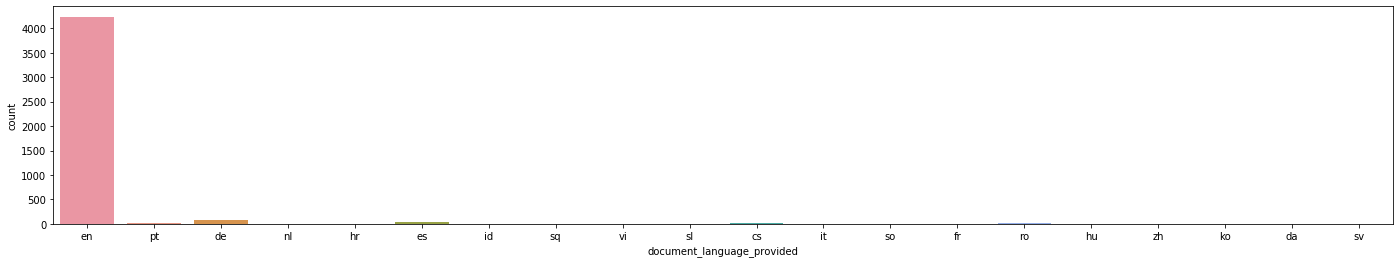

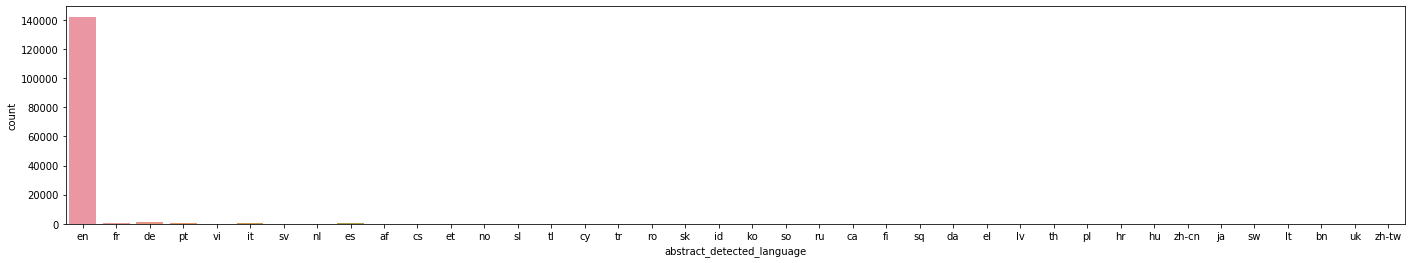

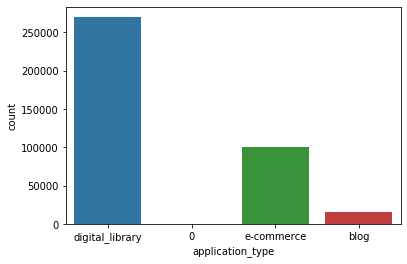

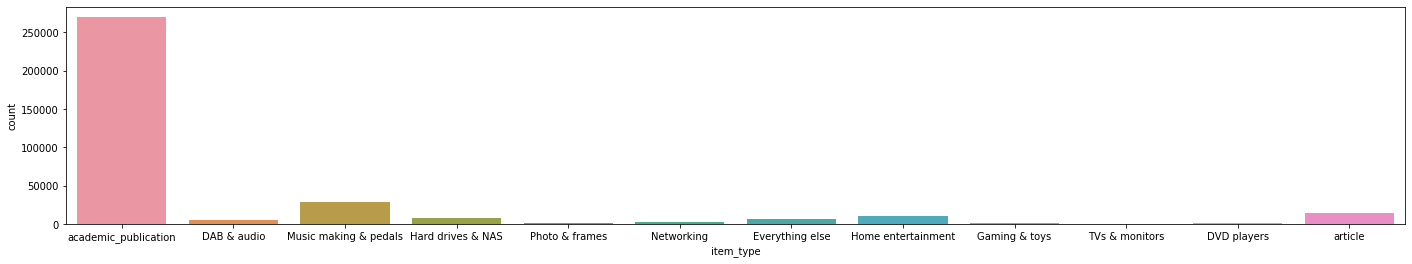

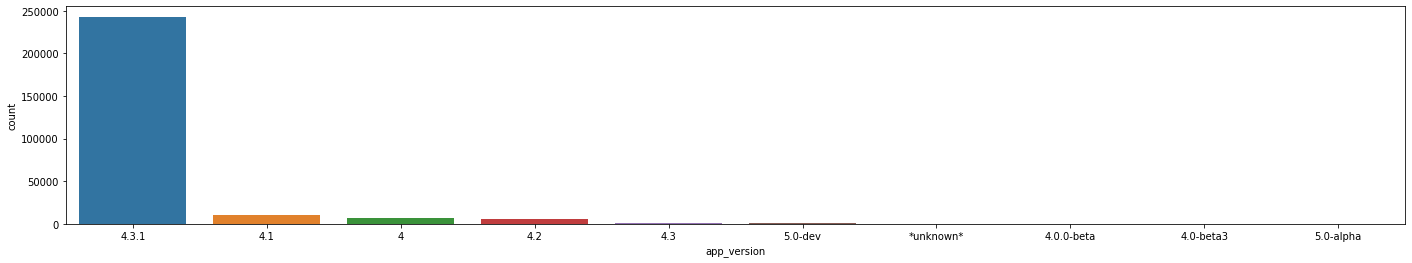

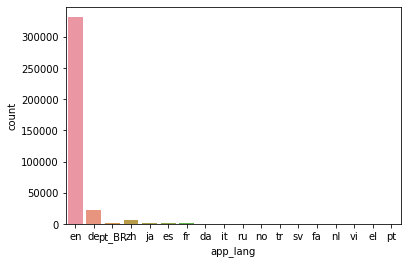

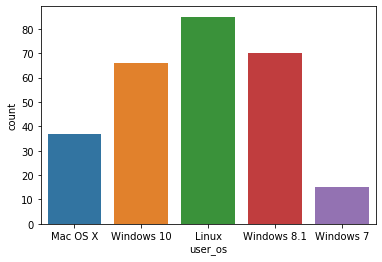

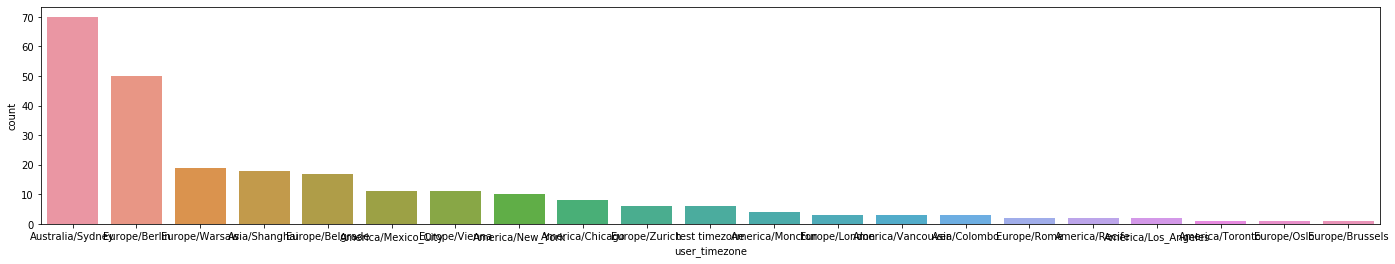

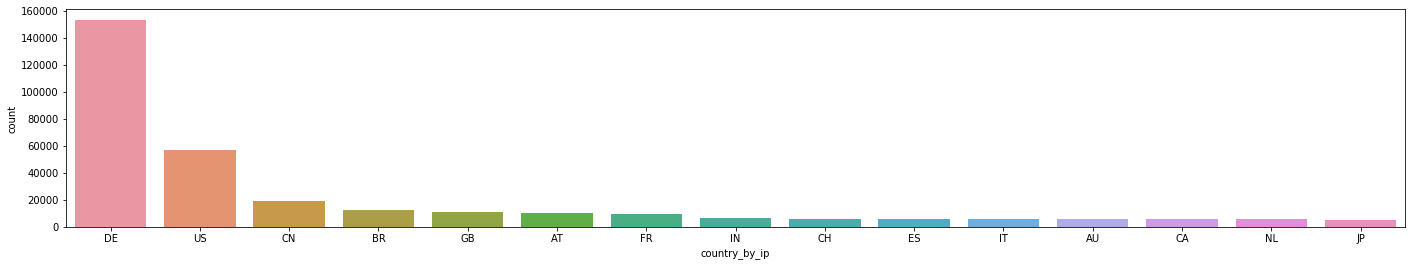

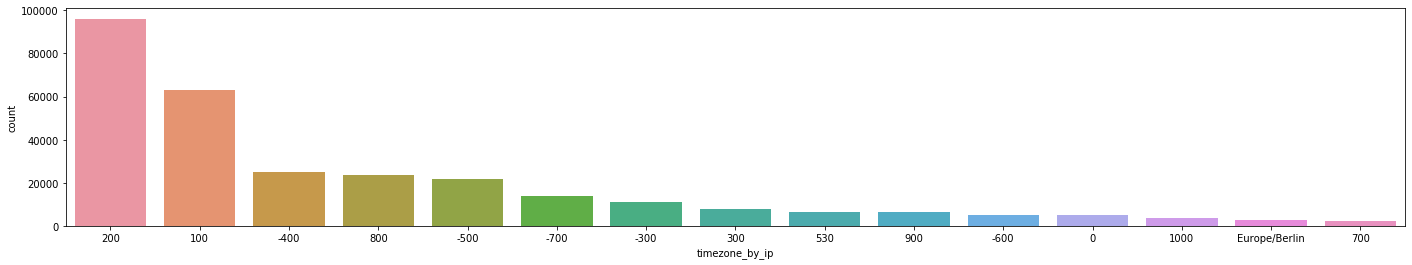

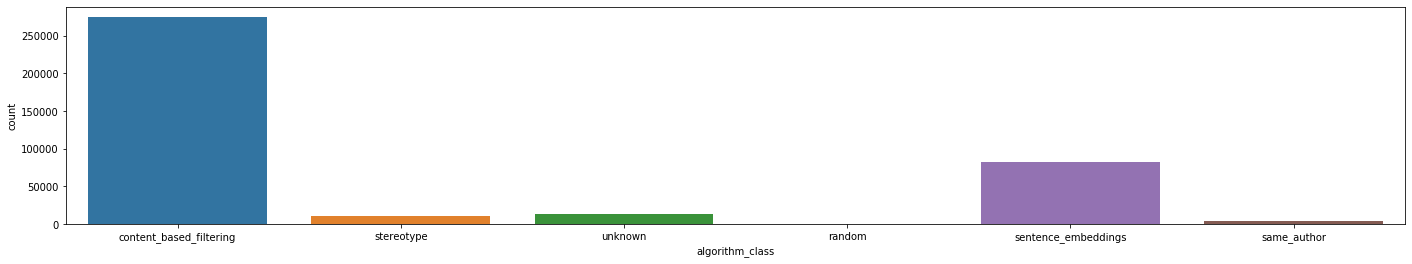

In [8]:
plt.figure(figsize=(24,4))
# sns.countplot(x="query_identifier", data=train_set)
# plt.show()
sns.countplot(x="document_language_provided", data=train_set)
plt.show()
plt.figure(figsize=(24,4))
sns.countplot(x="abstract_detected_language", data=train_set)
plt.show()
sns.countplot(x="application_type", data=train_set)
plt.show()
plt.figure(figsize=(24,4))
sns.countplot(x="item_type", data=train_set)
plt.show()
plt.figure(figsize=(24,4))
sns.countplot(x="app_version", data=train_set, order=pd.value_counts(train_set['app_version']).iloc[:10].index)
plt.show()
sns.countplot(x="app_lang", data=train_set)
plt.show()
sns.countplot(x="user_os", data=train_set)
plt.show()
# sns.countplot(x="user_os_version", data=train_set)
# plt.show()
# sns.countplot(x="user_java_version", data=train_set)
# plt.show()
plt.figure(figsize=(24,4))
sns.countplot(x="user_timezone", data=train_set, order=pd.value_counts(train_set['user_timezone']).index)
plt.show()
plt.figure(figsize=(24,4))
sns.countplot(x="country_by_ip", data=train_set, order=pd.value_counts(train_set['country_by_ip']).iloc[:15].index)
plt.show()
plt.figure(figsize=(24,4))
sns.countplot(x="timezone_by_ip", data=train_set, order=pd.value_counts(train_set['timezone_by_ip']).iloc[:15].index)
plt.show()
plt.figure(figsize=(24,4))
sns.countplot(x="algorithm_class", data=train_set)
plt.show()

### Encoding
- One hot
- Target
- Label

In [9]:
col = list(train_set.select_dtypes(include = ["object"]).columns)
train_enc = train_set[col].apply(LabelEncoder().fit_transform)
test_enc = test_set[col].apply(LabelEncoder().fit_transform)

In [10]:
train_enc = pd.concat([train_enc, train_set.drop(col, axis = 1)], axis = 1)
test_enc = pd.concat([test_enc, test_set.drop(col, axis = 1)], axis = 1)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_enc, train_enc["set_clicked"], test_size=0.2, random_state=122)

In [12]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(X_test, y_test)))
##Full Training
model.fit(train_enc, train_enc["set_clicked"])
y_pred = model.predict(test_enc)

C:\Users\vansh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of logistic regression classifier on test set: 0.98


C:\Users\vansh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [14]:
submit = pd.read_csv("tcdml1920-rec-click-pred--submission file.csv", index_col= 0)

In [15]:
submit["set_clicked"] = y_pred
submit.head()

,set_clicked
recommendation_set_id,
46914,0
46961,0
47012,0
47181,0
47240,0


In [16]:
submit.to_csv(r"C:\Users\vansh\TCD MAI\Machine Learning\GroupAssignment\RecAlgClickPred-Group\prediction.csv", index = True)